In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from gensim import models, corpora 
from itertools import combinations
import pyLDAvis
import pyLDAvis.gensim_models 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import umap
from sklearn.cluster import DBSCAN




import spacy 
import string
import random
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
# from pyod.models.xgbod import XGBOD
# from sentence_transformers import SentenceTransformer
# conda install pyod 
# conda install xgboost

/ocean/projects/cis240109p/mmarius/env/PNC2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Function to remove stop words (one with lemmatization and other without )

In [2]:
# to remove stop words 
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words
stop_words= list(stop_words) + ['card','I']
def remove_stopwords(text):
    
    # Convert to lowercase converts to tokens so easy to get lemmatize 
    doc = nlp(text.lower())
    cleaned_words = [
    token.lemma_  # Lemmatization
    for token in doc
    if token.lemma_ not in string.punctuation and token.lemma_ not in stop_words
    
]

    return " ".join(cleaned_words)


def remove_stopwords_woLemma(text):
    
    # Convert to lowercase converts to tokens so easy to get lemmatize 
    doc = nlp(text.lower())
    cleaned_words = [
    token.text  # Lemmatization
    for token in doc
    if token.text not in string.punctuation and token.text not in stop_words
    
]

    return " ".join(cleaned_words)

# Creating mult models and choosing best based on coherence score 

In [3]:
# Hyperparameter Tuning for Optimal Topics
def find_optimal_topics(corpus,dictionary,texts,min_topics=5, max_topics=25, step=5):
    coherence_values = []
    all_models = []
    
    for num_topics in range(min_topics, max_topics+1, step):
        model = models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            alpha='auto',
            eta='auto',
            passes=15
        )
        
        coherence = models.CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        ).get_coherence()
        
        coherence_values.append(coherence)
        all_models.append(model)
        print(f"Topics: {num_topics} | Coherence: {coherence:.3f}")
    
    optimal_index = np.argmax(coherence_values)
    return all_models[optimal_index], coherence_values[optimal_index]

# best_model, coherence_scores = find_optimal_topics()



# Computes LDA model stability via Jaccard 

In [4]:
# Stability Analysis with Jaccard Similarity
def jaccard_similarity(topic1, topic2):
    """Calculate Jaccard similarity between two topics"""
    set1 = set([word for word, _ in topic1])
    set2 = set([word for word, _ in topic2])
    return len(set1 & set2) / len(set1 | set2)

def stability_analysis(lda_model,num_runs=5):
    all_topics = []
    for _ in range(num_runs):
        model = models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=lda_model.num_topics,
            alpha='auto',  # Automatic asymmetric alpha
            eta='auto',    # Automatic asymmetric eta
            passes=15,
        )
        
        all_topics.append([model.show_topic(tid, topn=10) for tid in range(model.num_topics)]) #getting words and weights that contribute to topic
    
    # Compare topic words across runs
    similarities = []
    for run1, run2 in combinations(all_topics, 2):
        run_sim = [max(jaccard_similarity(t1, t2) for t2 in run2) for t1 in run1]
        similarities.append(np.mean(run_sim))
    
    return np.mean(similarities) # getting average jaccard similarity per run


In [5]:
train=pd.read_csv('/ocean/projects/cis240109p/mmarius/PNC_work/NLP/task-specific-datasets/banking_data/train.csv')
test=pd.read_csv('/ocean/projects/cis240109p/mmarius/PNC_work/NLP/task-specific-datasets/banking_data/test.csv')
data=pd.concat([train,test]).reset_index()
data=data.drop(columns=['index'])


In [6]:
data.describe()

,text,category
count,13083,13083
unique,13083,77
top,I am still waiting on my card?,card_payment_fee_charged
freq,1,227


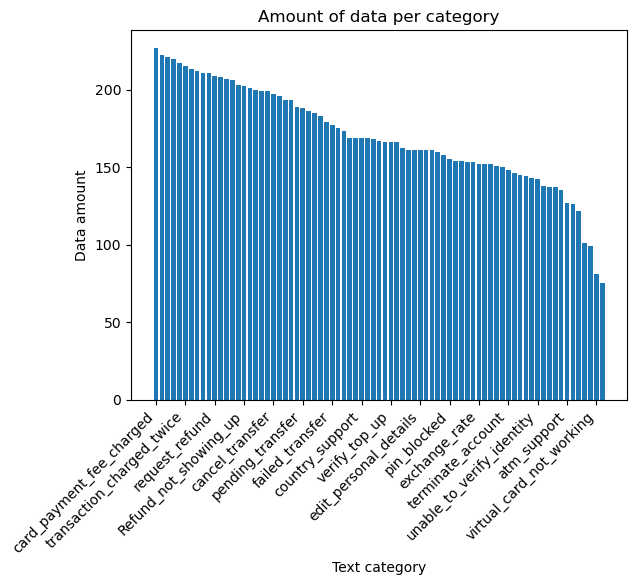

In [7]:

plt.bar(data['category'].value_counts().index ,data['category'].value_counts());
plt.xticks(data['category'].value_counts().index[::5]);
plt.xticks(rotation=45, ha='right');
plt.xlabel('Text category');
plt.ylabel('Data amount');
plt.title('Amount of data per category');


Text(0.5, 1.0, 'char count')

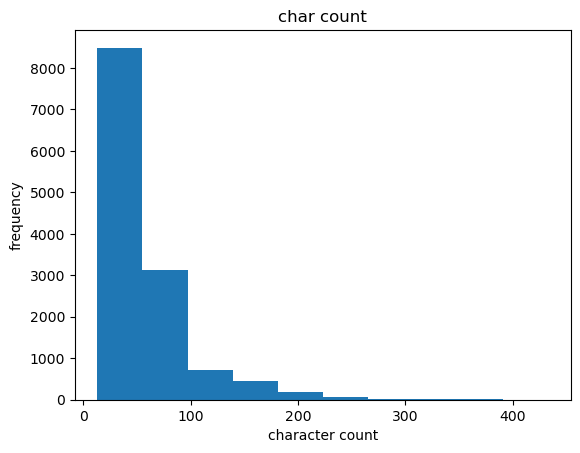

In [8]:
data['char_count'] = data['text'].str.len()
data['word_count'] = data['text'].str.split().str.len()
plt.hist(data['char_count']);
plt.xlabel('character count');
plt.ylabel('frequency');
plt.title('char count')

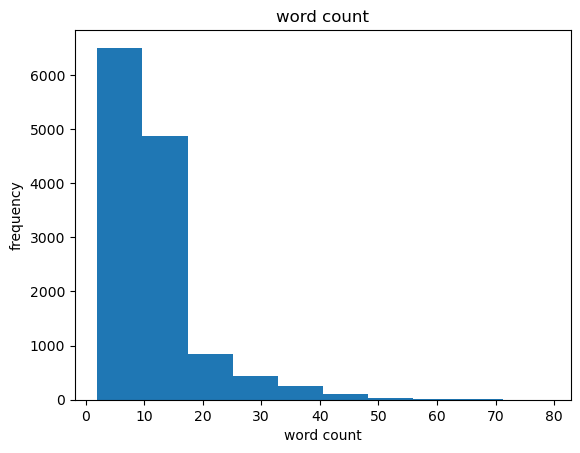

In [9]:
plt.hist(data['word_count']);
plt.xlabel('word count');
plt.ylabel('frequency');
plt.title('word count');

# Performing LDA model to find overall topics in text 

will later use this to define anomalies / non anomaly text 

In [10]:
# Creating bag of word from data
texts = [document.lower().split() for document in data['text'].apply(remove_stopwords)]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


In [11]:

best_model, coherence_score = find_optimal_topics(corpus=corpus,dictionary=dictionary,texts=texts,min_topics=5,max_topics=25,step=5)

Topics: 5 | Coherence: 0.352
Topics: 10 | Coherence: 0.409
Topics: 15 | Coherence: 0.427
Topics: 20 | Coherence: 0.550
Topics: 25 | Coherence: 0.549


# Coherence 
I'm using Coherence score to find the optimal number of topics based on word similarity per topic.
The lower the cohernece score the worse the topic/word realtionship is but the higher the coherence score, the better the words relate per topic.

good breakdown link 
https://stackoverflow.com/questions/54762690/evaluation-of-topic-modeling-how-to-understand-a-coherence-value-c-v-of-0-4


# Stability
Im performing Jaccard similarity test becuase I want to see how often I'll get the same topics for each run espically since i get new topics every run.

ranges from 0-1 higher scores means more similarity compared to lower scores 


# Perplixity 
(over all lower score the better)
Measures the models ability to make correct decisions 

# Chart analysis explanaition 

Right Side 

- Red Bars: Show term frequency within the selected topic

- Blue Bars: Show overall term frequency across all documents

- High λ: Shows common terms that strongly represent the topic

- Low λ: Reveals distinctive terms that uniquely identify the topic

Comparing bars:

- Large gap between red and blue: Term is distinctive to this topic

- Similar heights: Term appears similarly across multiple topics

Left Side 

- smaller circles means less data assigned to topic
- bigger circles means more data affiliated with topic 
- overlapping or close means similar in topic 



https://developer.ibm.com/tutorials/awb-lda-topic-modeling-text-analysis-python/#step-9-text-classification11

In [12]:

pyLDAvis.display.DEFAULT_DIV_STYLE = "background-color:white; width:100%; height:100%;"

best_visual = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary, mds='mmds')
pyLDAvis.display(best_visual)

(model with 25 topics and lemmatization)

the small topics actually dont make sense 


In [13]:
print(f"Model coherence (with lemmea): {coherence_score:.2f}" )
stability_score = stability_analysis(best_model,num_runs=10)
print(f"Average topic stability across runs(with lemmea): {stability_score:.2f}")

print(f"Model perplexity (with lemmea): {best_model.log_perplexity(corpus):.2f}" )

Model coherence (with lemmea): 0.55
Average topic stability across runs(with lemmea): 0.17
Model perplexity (with lemmea): -8.61


# Testing best model without lemmetization

In [14]:
# Creating bag of word from data
texts = [document.lower().split() for document in data['text'].apply(remove_stopwords_woLemma)]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


In [15]:
model = models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=best_model.__dict__['num_topics'],
            alpha='auto',
            eta='auto',
            passes=15
        )

In [16]:
# pyLDAvis.enable_notebook()
best_visual = pyLDAvis.gensim_models.prepare(model, corpus, dictionary, mds='mmds')
pyLDAvis.display(best_visual)

(without lemma 25 topics)
hard to understand topics also 

In [17]:
coherence = models.CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        ).get_coherence()
print(f"Model coherence (with lemmea): {coherence:.2f}" )
stability_score = stability_analysis(model,num_runs=10)
print(f"Average topic stability across runs(with lemmea): {stability_score:.2f}")

print(f"Model perplexity (with lemmea): {model.log_perplexity(corpus):.2f}" )

Model coherence (with lemmea): 0.53
Average topic stability across runs(with lemmea): 0.16
Model perplexity (with lemmea): -9.45


# Creating LDA Model by baised on requirments

1. word has to appear more than 2 times to be considered
2. removing words that appear in over 90 percent of the documents(or can manually remove words by adding to stop words)
3. Also not adding lemmatization since our text is short

In [18]:
# Creating bag of word from data
texts = [document.lower().split() for document in data['text'].apply(remove_stopwords)]
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below = 4, no_above= .9) # must appear 4 times in text and not be in 90% of the comments 
corpus = [dictionary.doc2bow(text) for text in texts]

In [19]:
model2 = models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=25,
            alpha='auto',
            eta='auto',
            passes=15
        )

In [20]:
# pyLDAvis.enable_notebook()
best_visual = pyLDAvis.gensim_models.prepare(model2, corpus, dictionary, mds='mmds')
pyLDAvis.display(best_visual)

In [21]:
coherence = models.CoherenceModel(
            model=model2,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        ).get_coherence()
print(f"Model coherence (with lemmea): {coherence:.2f}" )
stability_score = stability_analysis(model2,num_runs=10)
print(f"Average topic stability across runs(with lemmea): {stability_score:.2f}")

print(f"Model perplexity (with lemmea): {model2.log_perplexity(corpus):.2f}" )

Model coherence (with lemmea): 0.56
Average topic stability across runs(with lemmea): 0.16
Model perplexity (with lemmea): -8.59


#### notes ######
Based on lda model u choose, maybe look at the topics with the least amount of data points assigned to it( possibily ight be anomalas)

Asked on how to actaully analyze becaue alot of topics dont make sense 



# Actually getting words for each topic and assigning label

In [22]:

# Get topic distribution for each document
doc_topics = [] # will contain all labels for each dataset
for doc in corpus:
    # Get topic probabilities for document
    topic_probs = best_model.get_document_topics(doc)
    # returns ( label and probability )
    dominant_topic = max(topic_probs, key=lambda x: x[1]) # returns ( label and probability )
    # later use to make labels if topic is good 
    doc_topics.append(dominant_topic[0])



 

In [1]:
# topics_list = []

# for topic_id in range(best_model.num_topics):
#     topic_words = best_model.show_topic(topic_id, num_words)
    
#     # Create a dictionary for the topic
#     topic_dict = {'Topic_ID': topic_id}
    
#     # Add words and probabilities to the dictionary
#     for i, (word, prob) in enumerate(topic_words):
#         topic_dict[f'Word_{i+1}'] = word
#         # topic_dict[f'Prob_{i+1}'] = prob
    
#     topics_list.append(topic_dict)

#     topics_df = pd.DataFrame(topics_list)

# # Reorder columns for better readability
# columns = ['Topic_ID'] + [f'Word_{i+1}' for i in range(num_words)]
# topics_df = pd.DataFrame(topics_list)[columns]


# Run the Sbert.py file to vectorize the data 

In [3]:
# Get embedding of data 
vec_data= np.load('/ocean/projects/cis240109p/mmarius/PNC_work/NLP/embedding.npy')

# Clustering bert embeddings it's self for possible anaomaly detection

Attempting Kmeans (centroid based clustering)

In [3]:
# finding optimal number of clusters

inertia = []  # Stores the sum of squared distances (WCSS)
silhouette_scores=[] # Stores sil scores

K_range = range(2, 51)  
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(vec_data)
    inertia.append(kmeans.inertia_)  # Sum of squared distances to centroids
    labels = kmeans.fit_predict(vec_data)
    score = silhouette_score(vec_data, labels)
    silhouette_scores.append(score)

# Plot Elbow Curve
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.show()


: 

: 

In [ ]:
# Plot Silhouette Scores
plt.plot(range(2, 51), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()

: 

: 

K mean with 91 labels/ clusters shown from visuals

In [4]:
# K means model based on graph above 

kmeans = KMeans(n_clusters=91, random_state=42)
labels_km = kmeans.fit_predict(vec_data)
centroids = kmeans.cluster_centers_


/tmp/ipykernel_1462304/3584285860.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


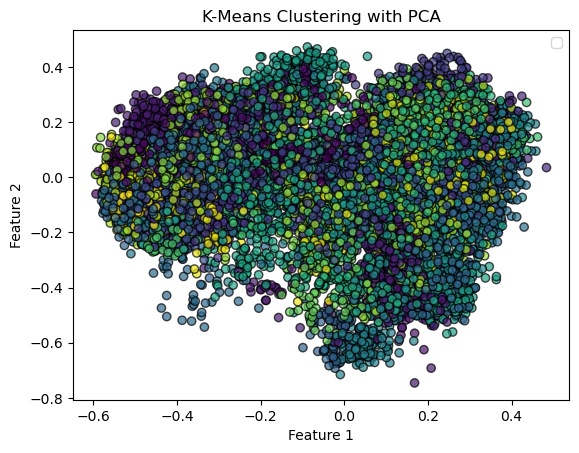

In [5]:
# vizulazing clusters via PCA
pca=PCA(n_components=2)
data_pca = pca.fit_transform(vec_data)

plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels_km, cmap='viridis', alpha=0.7, edgecolors='k')

# Plot centroids
# plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')

# Labels and title
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-Means Clustering with PCA')
plt.legend()
plt.show()

attempting T-SNE reduction ()

/tmp/ipykernel_1462304/2246234517.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


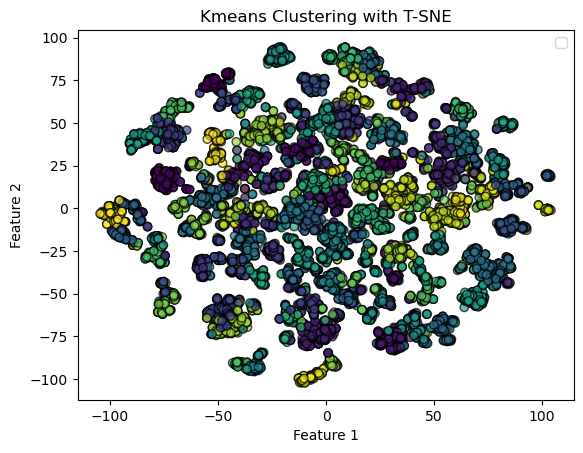

In [6]:
# Tsne instead of PCA 
# if this works , else run line below
# tsne = TSNE(n_components=2)
# data_ts = tsne.fit_transform(vec_data)

data_ts= np.load('/ocean/projects/cis240109p/mmarius/PNC_work/NLP/TSNE.npy')


# plot data 
plt.scatter(data_ts[:, 0], data_ts[:, 1], c=labels_km, cmap='viridis', alpha=0.7, edgecolors='k')
# Plot centroids
# plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')

# Labels and title
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Kmeans Clustering with T-SNE')
plt.legend()
plt.show()

Attempting with U-Map (currently not finding best U-map model)

/tmp/ipykernel_1462304/3791070010.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


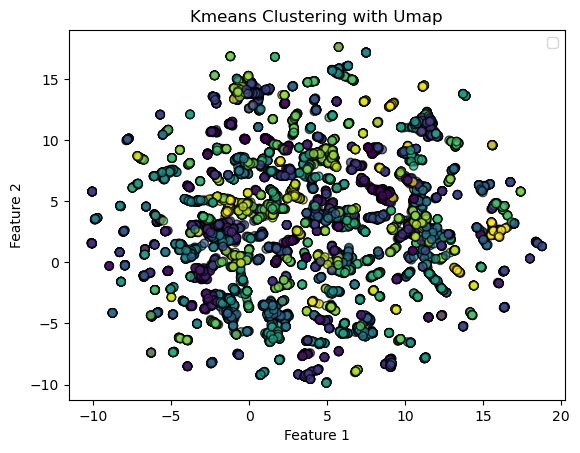

In [7]:
reducer = umap.UMAP(n_neighbors=5, min_dist=0.1, n_components=2)

# Fit and transform the data
data_um = reducer.fit_transform(vec_data)

#Plot data 
plt.scatter(data_um[:, 0], data_um[:, 1], c=labels_km, cmap='viridis', alpha=0.7, edgecolors='k')
# Plot centroids
# plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')

# Labels and title
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Kmeans Clustering with Umap')
plt.legend()
plt.show()


for u map will have to play with params to get something reasonable, just MVP for now

# Attempting DBSCAN ( based on high density regions)

with pca 

Number of clusters found: 254


/tmp/ipykernel_1462304/3746034460.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


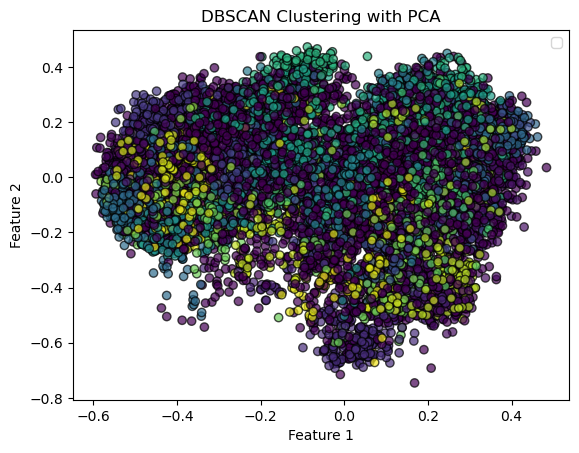

In [8]:
db=DBSCAN()
labels_db = db.fit_predict(vec_data)
# getting total amount of clusters 
n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
print(f"Number of clusters found: {n_clusters}")


plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels_db, cmap='viridis', alpha=0.7, edgecolors='k')

# Plot centroids
# plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')

# Labels and title
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN Clustering with PCA')
plt.legend()
plt.show()

# ploting with pca 


With TSNE

/tmp/ipykernel_1462304/3297209669.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


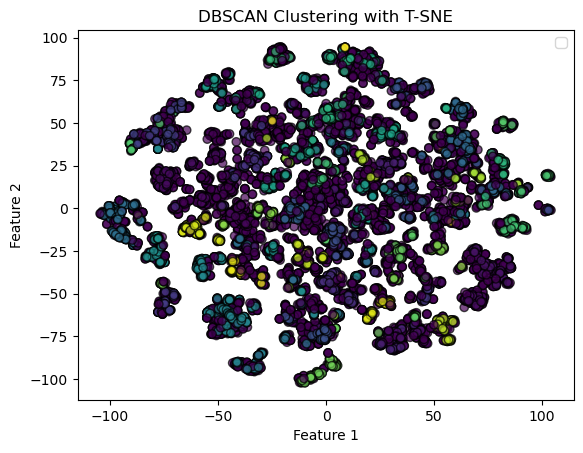

In [9]:

# plot data 
plt.scatter(data_ts[:, 0], data_ts[:, 1], c=labels_db, cmap='viridis', alpha=0.7, edgecolors='k')
# Plot centroids
# plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')

# Labels and title
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN Clustering with T-SNE')
plt.legend()
plt.show()

With UMAP

/tmp/ipykernel_1462304/1250337716.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


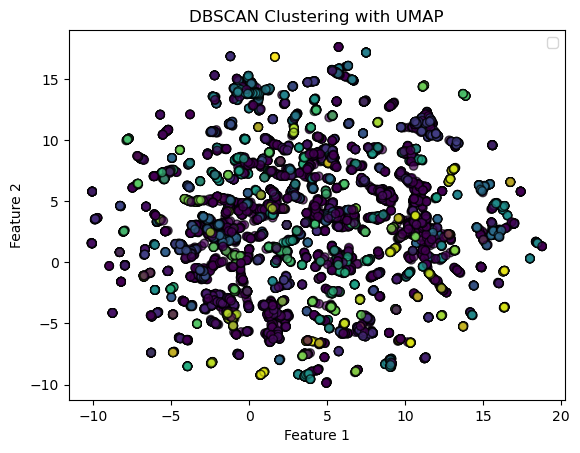

In [10]:
#Plot data 
plt.scatter(data_um[:, 0], data_um[:, 1], c=labels_db, cmap='viridis', alpha=0.7, edgecolors='k')
# Plot centroids
# plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')

# Labels and title
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN Clustering with UMAP')
plt.legend()
plt.show()


After reviewing TSNE is the best and also Kmeans out performs DBSCAN

Note : didnt try to find best dbscan 


Next try to import all of these differnt MODEL's to finally move away form ONECLASSSVM

Model creation 

In [ ]:
# creating model 
model = OneClassSVM(
    kernel='poly',     # Radial basis function kernel
    gamma=0.1,        # Kernel coefficient
    nu=0.1           # Upper bound on fraction of outliers
)

# Train the model
model.fit(train_x)

# Make predictions
y_pred = model.predict(test_x)

# in this case since non anomaly is the minority ( the model thinks non anomalies is the anomalies ) or in this case the anamoly are the " non anamanious comments"

####### Orig predictions #########
y_pred = np.where(y_pred == -1, 0, 1)  

########### use anomaly scores to get predictions  ###########
anomaly_scores = model.score_samples(test_x) # lower scores more anominous higher scores less
threshold = np.percentile(anomaly_scores, 95)  # 5th percentile as threshold ( captures the lowest scores can lower percitle to capture the most bottomist)
predictions = np.where(anomaly_scores > threshold, 0, 1)  # 1 for normal, -1 for anomalies


# or can use anomaly score directly and find x percent for cutoff  
# Convert scores to probabilities (0 to 1 scale)
normalized_scores = (anomaly_scores - np.min(anomaly_scores)) / (np.max(anomaly_scores) - np.min(anomaly_scores))
predictions_norm = np.where(normalized_scores > .95, 0, 1) 

# Differnce betweeen model decision and mines
- model.predict uses offset (lower value)
- im using threshold (higher value)

In [ ]:
threshold

0.015101291795246104

In [ ]:
model.offset_

array([0.00917095])

In [ ]:
print(accuracy_score(test_y,y_pred))
print(classification_report(test_y,y_pred))

0.6324035154757356
              precision    recall  f1-score   support

           0       0.33      0.15      0.20       834
           1       0.68      0.86      0.76      1783

    accuracy                           0.63      2617
   macro avg       0.51      0.50      0.48      2617
weighted avg       0.57      0.63      0.58      2617



In [ ]:
# Based on 95 percentile
print(accuracy_score(test_y,predictions))
print(classification_report(test_y,predictions))

0.6763469621704241
              precision    recall  f1-score   support

           0       0.45      0.07      0.12       834
           1       0.69      0.96      0.80      1783

    accuracy                           0.68      2617
   macro avg       0.57      0.52      0.46      2617
weighted avg       0.61      0.68      0.59      2617



In [ ]:
# Based on  normlization
print(accuracy_score(test_y,predictions_norm))
print(classification_report(test_y,predictions_norm))

0.6820787160871227
              precision    recall  f1-score   support

           0       0.62      0.01      0.01       834
           1       0.68      1.00      0.81      1783

    accuracy                           0.68      2617
   macro avg       0.65      0.50      0.41      2617
weighted avg       0.66      0.68      0.56      2617



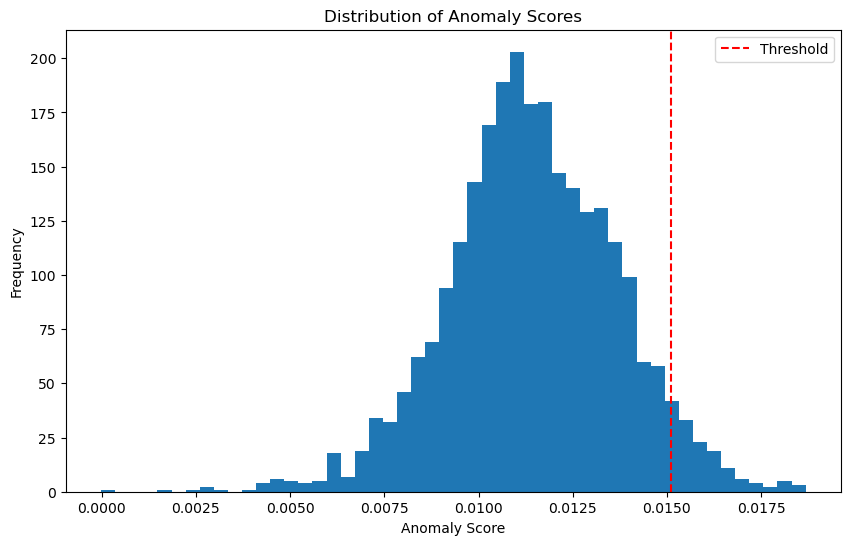

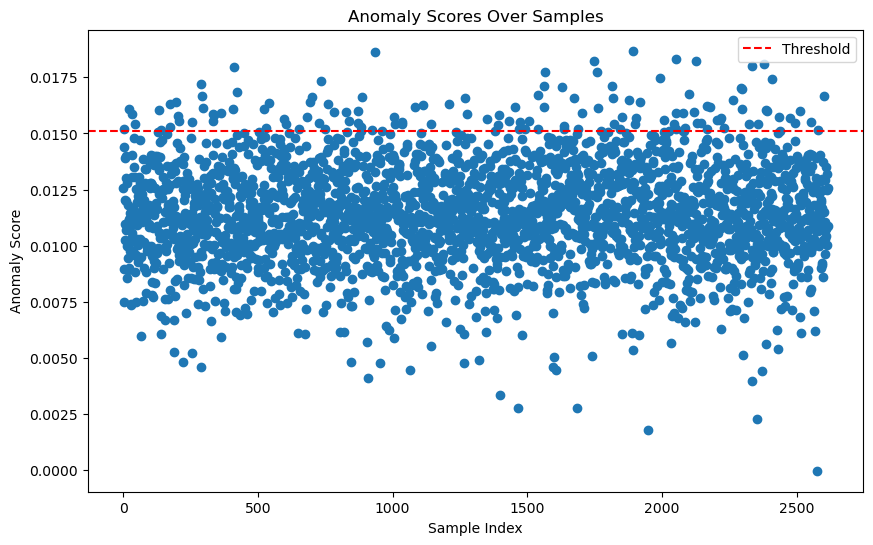

In [ ]:
# Plot score distribution
plt.figure(figsize=(10, 6))
plt.hist(anomaly_scores, bins=50)
plt.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot scores over time
plt.figure(figsize=(10, 6))
plt.scatter(range(0,len(anomaly_scores)),anomaly_scores)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Anomaly Scores Over Samples')
plt.xlabel('Sample Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.show()


# ROC CURVE

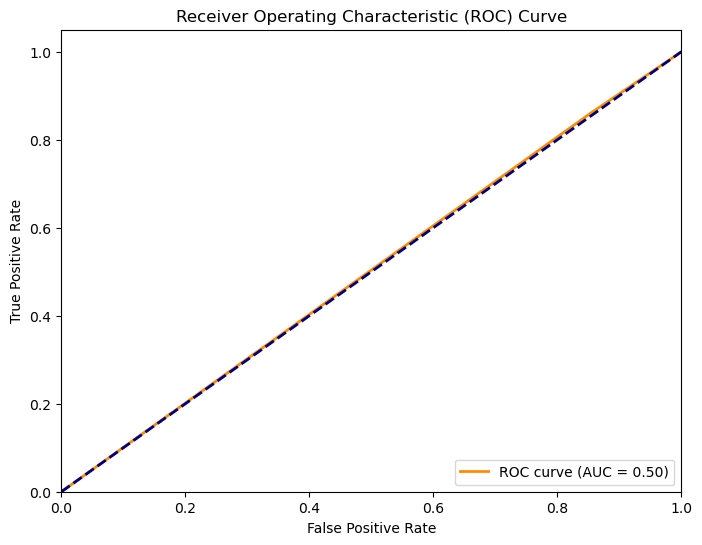

In [ ]:
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Confusion Matrix

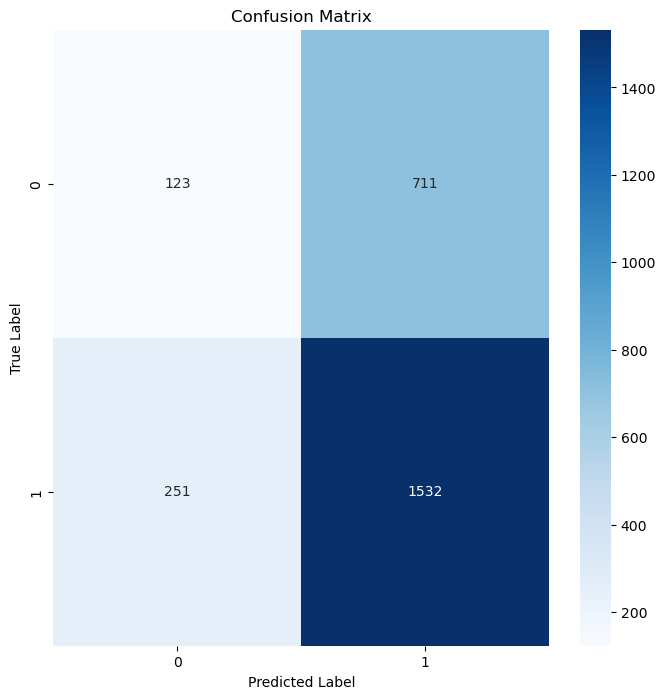

In [ ]:
cm = confusion_matrix(test_y, y_pred)

# Create visualization
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Results  
As a result we can see we can currentl see that the model is terrbile. we should go back and revise how we're creating our labels since we have more anomlies than actual normal text which should be the other way around. Also These scores are no better than random guessing   

# TO DO
Try new models from paper

# Next step is try to create the PolyAi NN model 

Try topic modeling for example LDA to choose your anaomalies(look at topics that are anaomalies and see what data points contribute to it ) and make anom or non anaom based on this 

perecision recall curve

change weights if needed because wee need to 100% evade letting fraud pass by
Time series
Link fraudalint score to amount of credit cards and to credit card ( peopel below x credit score have a haigher fraud level)

mcc code doesnt always capture all of the finer merchants 

maybe look into payment network and then use this to make own categories
